In [1]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import linalg
import itertools

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LQR Finite-Horizon Approach

### Single Step

In [2]:
def linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, r, m):
    """ Finite LQR Setup for freeway onramp
    Parameters:
    ----------
        delta, gamma: floats
            tunable paramaters for pre-merge freeway entering and leaving rates
        m0   : float
            initial number of cars in the merge area on a given interval 
        qi, r, m : floats
            q_k weights in Q matrix
            r weights in R matrix
            m weights in M matrix


    Return
    -------
        A : ndarray of shape (6,6)
            State evolution equation matrix for q(t)
        B : ndarray of shape (6,1)
            State evolution equation matrix for u(t)
        Q : ndarray of shape (6,6)
            Cost functional matrix for q(t)
        R : ndarray of shape (1,1)
            Cost functional matrix for u(t)
        M : ndarray of shape (6,6)
            Cost functional matrix for q(tf)
    """
    # Taylor Series expand the rate of cars leaving the merging area to linearize
    f_m = -delta*m0 - delta*m0**2/c + (-delta - 2*delta*m0/c)

    # [alpha, beta, m, l, n, q]
    A = np.array([
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,f_m,0,gamma,0],
        [0,0,-f_m,0,0,0],
        [1,0,0,0,-gamma,0],
        [0,1,0,0,0,0]
    ])

    B = np.array([0,0,1,0,0,-1]).reshape(-1,1)
    Q = np.diag(np.array([q1, q2, q3, q4, q5, q6]))
    R = np.array([[r]])
    M = np.diag(np.array([0,0,1,1,1,1]))*m

    # TODO: Endpoint Cost?
    # TODO: Infinite Time?

    return A, B, Q, R, M

In [8]:
def onramp_solver_finite_horizon(A, B, Q, R, M, y0, t0, tf):
    """ Onramp solver for Finite Horizon LQR
        Uses Idea from 19.2 to find P(t) and then solve Ricatti

    Parameters:
    -----------
        A : ndarray of shape (6,6)
            State evolution equation matrix for q(t)
        B : ndarray of shape (6,1)
            State evolution equation matrix for u(t)
        Q : ndarray of shape (6,6)
            Cost functional matrix for q(t)
        R : ndarray of shape (1,1)
            Cost functional matrix for u(t)
        M : ndarray of shape (6,6)
            Cost functional matrix for q(tf)
    """
    # Setup R inverse
    R_inv = np.linalg.inv(R)


    # Setup the evolution equation for the Riccati 
    # equation (the linear 2D version)
    def riccati(t,x):
        dxdt = np.zeros((72))
        x=x.reshape((12,6))
        X = x[:6]
        Y = x[6:]
        dxdt[:36] = ((A @ X) + (0.5*B @ R_inv @ B.T @ Y)).flatten()
        dxdt[36:] = ((2*Q @ X) - (A.T @ Y)).flatten()
        return dxdt

    # Solve the Riccati equation, and make sure to
    # save the output densely so we can interpolate later on
    xf = np.zeros((72))
    xf[:36] = np.eye(6).flatten() # X(tf)
    xf[36:] = (-2*M).flatten() # Y(tf)
    p_sol = solve_ivp(riccati, [tf,t0], xf, dense_output=True)

    # Setup the evolution equation with optimal control selected
    def onramp_evolve(t,y,p_sol):
        sol_p = p_sol.sol(t).reshape((12,6))
        X = sol_p[:6]
        Y = sol_p[6:]
        X_inv = np.linalg.inv(X)
        P = -.5*Y@X_inv
        return (A-B@R_inv@B.T@P)@y

    # Solve the forward model for the onramp,
    # Then compute the optimal control from the optimal state,
    # and plot the results
    final_sol = solve_ivp(onramp_evolve, [t0,tf], y0, args=[p_sol], dense_output=True)

    return final_sol, p_sol

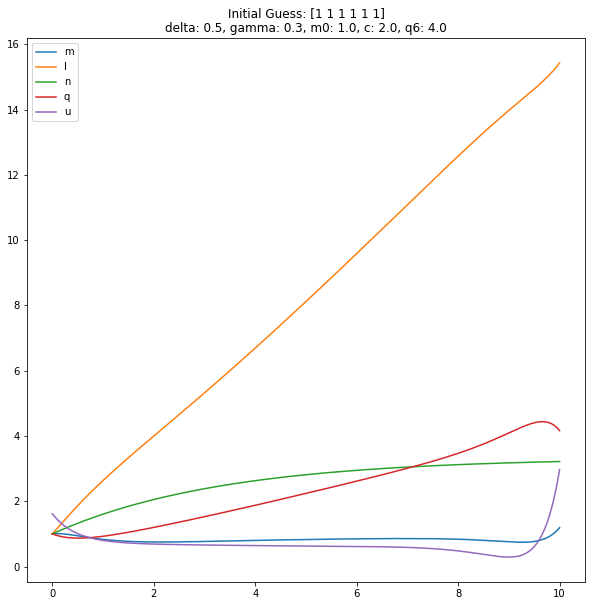

In [9]:
"""Run a single test"""
# Setup initial values and conditions for onramp
# delta, gamma, m0, c = 0.5, 0.3, 1.0, 4.0
# q1, q2, q3, q4, q5, q6 = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
# r, m = 1.0, 1.0

delta, gamma, m0, c = 0.5, 0.3, 1.0, 2.0
q1, q2, q3, q4, q5, q6 = 0.0, 0.0, 1.0, 1.0, 1.0, 4.0
r, m = 1.0, 1.0
n_count = 1001
tf = 10
y0 = np.array([1,1,1,1,1,1])
t_space = np.linspace(0,tf,n_count)

# Get LQR Matrices and Solve the Ricatti Equations for the state and costate
A, B, Q, R, M = linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, r, m)
final_sol, p_sol = onramp_solver_finite_horizon(A, B, Q, R, M, y0, 0, tf)
R_inv = np.linalg.inv(R)

# Unpack the solution
solution = final_sol.sol(t_space)
alpha, beta, m, l, n, q = solution

# Calculate the optimal control
X = p_sol.sol(t_space)[:36,:]
Y = p_sol.sol(t_space)[36:,:]
u = np.zeros(n_count)
for t in range(n_count):
    X_t = X[:,t].reshape((6,6))
    Y_t = Y[:,t].reshape((6,6))
    X_t_inv = np.linalg.inv(X_t)
    P = -0.5*Y_t @ X_t_inv
    u[t] = (-R_inv @ B.T @ P @ solution[:,t].reshape(-1,1))[0][0]

plt.figure(figsize=(10,10))
# plt.plot(t_space, alpha, label="alpha")
# plt.plot(t_space, beta, label="beta")
plt.plot(t_space, m, label=f"m")
plt.plot(t_space, l, label=f"l")
plt.plot(t_space, n, label=f"n")
plt.plot(t_space, q, label=f"q")
plt.plot(t_space, u, label=f"u")
plt.title(f"Initial Guess: {y0}\ndelta: {delta}, gamma: {gamma}, m0: {m0}, c: {c}, q6: {q6}")
plt.legend()
plt.savefig(f"LQR_figures/Finite_{y0}_{delta}_{gamma}_{m0}_{c}_{q6}.jpg", transparent=False)
plt.show()

In [12]:
"""Run Gridsearch over multiple values"""
# Setup initial values and conditions for onramp
# delta, gamma, m0, c = 0.5, 0.3, 1.0, 4.0
# q1, q2, q3, q4, q5, q6 = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
# r, m = 1.0, 1.0

deltas = [0.5, 0.7, 1.0]
gammas = [0.3, 0.7, 1.0]
m0s = [0.5, 1.0]
cs = [2.0, 3.0, 4.0]
q1, q2, q3, q4, q5, q6s = 0.0, 0.0, 1.0, 1.0, 1.0, [1.0, 2.0, 4.0]
r, m = 1.0, 1.0
n_count = 1001
tf = 10
y0 = np.array([1,1,1,1,1,1])
t_space = np.linspace(0,tf,n_count)

for combo in itertools.product(deltas, gammas, m0s, cs, q6s):
    # Unpack the combo
    delta, gamma, m0, c, q6 = combo
    r, m = 1.0, 1.0

    # Get LQR Matrices and Solve the Ricatti Equations for the state and costate
    A, B, Q, R, M = linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, r, m)
    final_sol, p_sol = onramp_solver_finite_horizon(A, B, Q, R, M, y0, 0, tf)
    R_inv = np.linalg.inv(R)

    # Unpack the solution
    solution = final_sol.sol(t_space)
    alpha, beta, m, l, n, q = solution

    # Calculate the optimal control
    X = p_sol.sol(t_space)[:36,:]
    Y = p_sol.sol(t_space)[36:,:]
    u = np.zeros(n_count)
    for t in range(n_count):
        X_t = X[:,t].reshape((6,6))
        Y_t = Y[:,t].reshape((6,6))
        X_t_inv = np.linalg.inv(X_t)
        P = -0.5*Y_t @ X_t_inv
        u[t] = (-R_inv @ B.T @ P @ solution[:,t].reshape(-1,1))[0][0]

    plt.figure(figsize=(10,10))
    # plt.plot(t_space, alpha, label="alpha")
    # plt.plot(t_space, beta, label="beta")
    plt.plot(t_space, m, label=f"m")
    plt.plot(t_space, l, label=f"l")
    plt.plot(t_space, n, label=f"n")
    plt.plot(t_space, q, label=f"q")
    plt.plot(t_space, u, label=f"u")
    plt.title(f"Initial Guess: {y0}\ndelta: {delta}, gamma: {gamma}, m0: {m0}, c: {c}, q6: {q6}")
    plt.legend()
    plt.savefig(f"LQR_figures/single_step/Finite_{y0}_{delta}_{gamma}_{m0}_{c}_{q6}.jpg", transparent=False)
    plt.close()

### Multi-Step

In [54]:
def multi_step_onramp_finite_horizon(A, B, Q, R, M, y0, tf, num_intervals=10):
    """ Multi-step Onramp solver for Finite Horizon LQR
    Uses Idea from 19.2 to find P(t) and then solve Ricatti

    Parameters:
    -----------
        A : ndarray of shape (6,6)
            State evolution equation matrix for q(t)
        B : ndarray of shape (6,1)
            State evolution equation matrix for u(t)
        Q : ndarray of shape (6,6)
            Cost functional matrix for q(t)
        R : ndarray of shape (1,1)
            Cost functional matrix for u(t)
        M : ndarray of shape (6,6)
            Cost functional matrix for q(tf)
    """
    # Setup Initial Conditions
    R_inv = np.linalg.inv(R)
    y0 = np.array([1,1,1,1,1,1])
    n_count = 1001
    time_intervals = np.linspace(0,tf,num_intervals+1)

    # Initialize Solution Arrays
    alpha = np.zeros(n_count*num_intervals)
    beta = np.zeros(n_count*num_intervals)
    m = np.zeros(n_count*num_intervals)
    l = np.zeros(n_count*num_intervals)
    n = np.zeros(n_count*num_intervals)
    q = np.zeros(n_count*num_intervals)
    u = np.zeros(n_count*num_intervals)

    for i in range(len(time_intervals)-1):
        # Setup and solve LQR over the finite interval
        t0, tf = time_intervals[i], time_intervals[i+1]
        t_space = np.linspace(time_intervals[i], time_intervals[i+1], n_count)
        final_sol, p_sol = onramp_solver_finite_horizon(A, B, Q, R, M, y0, t0, tf)
        i0, i1 = i*n_count, (i+1)*n_count
        
        # Unpack the solution
        solution = final_sol.sol(t_space)
        alpha[i0:i1], beta[i0:i1], m[i0:i1], l[i0:i1], n[i0:i1], q[i0:i1] = solution

        # Calculate the optimal control
        X = p_sol.sol(t_space)[:36,:]
        Y = p_sol.sol(t_space)[36:,:]
        for t in range(n_count):
            X_t = X[:,t].reshape((6,6))
            Y_t = Y[:,t].reshape((6,6))
            X_t_inv = np.linalg.inv(X_t)
            P = -0.5*Y_t @ X_t_inv
            u[i0 + t] = (-R_inv @ B.T @ P @ solution[:,t].reshape(-1,1))[0][0]

        # Update y0 
        y0 = solution[:,-1]

    return alpha, beta, m, l, n, q, u, 

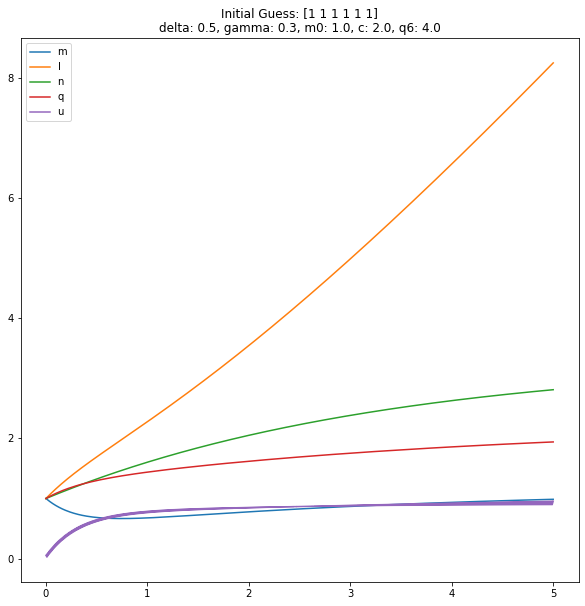

In [58]:
"""Run a single test on multi-step LQR"""

delta, gamma, m0, c = 0.5, 0.3, 1.0, 2.0
q1, q2, q3, q4, q5, q6 = 0.0, 0.0, 1.0, 0.0, 4.0, 4.0
r, m = 1.0, 1.0
n_count = 1001
tf = 5
num_intervals = 500
y0 = np.array([1,1,1,1,1,1])
t_space = np.linspace(0,tf,num_intervals*n_count)

# Get LQR Matrices and Solve the Ricatti Equations for the state and costate
A, B, Q, R, M = linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, r, m)
alpha, beta, m, l, n, q, u = multi_step_onramp_finite_horizon(A, B, Q, R, M, y0, tf, num_intervals)

plt.figure(figsize=(10,10))
plt.plot(t_space, m, label=f"m")
plt.plot(t_space, l, label=f"l")
plt.plot(t_space, n, label=f"n")
plt.plot(t_space, q, label=f"q")
plt.plot(t_space, u, label=f"u")
plt.title(f"Initial Guess: {y0}\ndelta: {delta}, gamma: {gamma}, m0: {m0}, c: {c}, q6: {q6}")
plt.legend()
plt.show()

In [59]:
"""Run Multi-step over multiple parameters for gridsearching"""
# Setup initial values and conditions for onramp
# delta, gamma, m0, c = 0.5, 0.3, 1.0, 4.0
# q1, q2, q3, q4, q5, q6 = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
# r, m = 1.0, 1.0

deltas = [0.5, 1.0]
gammas = [0.7, 1.0]
m0s = [0.5, 1.0]
cs = [2.0, 4.0]
q1, q2, q3, q4, q5, q6s = 0.0, 0.0, 1.0, 0.0, 1.0, [2.0, 4.0]
r, m = 1.0, 1.0
n_count = 1001
tf = 5
num_intervals = 500
y0 = np.array([1,1,1,1,1,1])
t_space = np.linspace(0,tf,num_intervals*n_count)

for combo in itertools.product(deltas, gammas, m0s, cs, q6s):
    # Unpack the combo
    delta, gamma, m0, c, q6 = combo
    r, m = 1.0, 1.0

    # Get LQR Matrices and Solve the Ricatti Equations for the state and costate
    A, B, Q, R, M = linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, r, m)
    alpha, beta, m, l, n, q, u = multi_step_onramp_finite_horizon(A, B, Q, R, M, y0, tf, num_intervals)

    plt.figure(figsize=(10,10))
    # plt.plot(t_space, alpha, label="alpha")
    # plt.plot(t_space, beta, label="beta")
    plt.plot(t_space, m, label=f"m")
    plt.plot(t_space, l, label=f"l")
    plt.plot(t_space, n, label=f"n")
    plt.plot(t_space, q, label=f"q")
    plt.plot(t_space, u, label=f"u")
    plt.xlabel('t')
    plt.ylabel('rate')
    plt.title(f"Initial Guess: {y0}\ndelta: {delta}, gamma: {gamma}, m0: {m0}, c: {c}, q6: {q6}")
    plt.legend()
    plt.savefig(f"LQR_figures/multi_step/Finite_{y0}_{delta}_{gamma}_{m0}_{c}_{q6}.jpg", transparent=False)
    plt.close()